In [1]:
!pip install -q anemoi-inference[huggingface]==0.4.3 anemoi-models==0.2.1
!pip install -q earthkit-regrid==0.3.4 ecmwf-opendata
!pip install -q flash_attn

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anemoi-training 0.3.3 requires anemoi-models>=0.4.1, but you have anemoi-models 0.2.1 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anemoi-transform 0.1.2 requires earthkit-regrid>=0.4, but you have earthkit-regrid 0.3.4 which is incompatible.


In [1]:
import datetime
from collections import defaultdict

import numpy as np
import earthkit.data as ekd
import earthkit.regrid as ekr

from anemoi.inference.runners.simple import SimpleRunner
from anemoi.inference.outputs.printer import print_state

from ecmwf.opendata import Client as OpendataClient

In [2]:
PARAM_SFC = ["10u", "10v", "2d", "2t", "msl", "skt", "sp", "tcw", "lsm", "z", "slor", "sdor"]
PARAM_PL = ["gh", "t", "u", "v", "w", "q"]
LEVELS = [1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100, 50]

In [3]:
DATE = OpendataClient().latest()

In [4]:
print("Initial date is", DATE)

Initial date is 2025-03-11 06:00:00


In [5]:
def get_open_data(param, levelist=[]):
    fields = defaultdict(list)
    # Get the data for the current date and the previous date
    for date in [DATE - datetime.timedelta(hours=6), DATE]:
        data = ekd.from_source("ecmwf-open-data", date=date, param=param, levelist=levelist)
        for f in data:
            # Open data is between -180 and 180, we need to shift it to 0-360
            assert f.to_numpy().shape == (721,1440)
            values = np.roll(f.to_numpy(), -f.shape[1] // 2, axis=1)
            # Interpolate the data to from 0.25 to N320
            values = ekr.interpolate(values, {"grid": (0.25, 0.25)}, {"grid": "N320"})
            # Add the values to the list
            name = f"{f.metadata('param')}_{f.metadata('levelist')}" if levelist else f.metadata("param")
            fields[name].append(values)

    # Create a single matrix for each parameter
    for param, values in fields.items():
        fields[param] = np.stack(values)

    return fields

In [6]:
fields = {}

In [7]:
fields.update(get_open_data(param=PARAM_SFC))

In [8]:
fields.update(get_open_data(param=PARAM_PL, levelist=LEVELS))

In [9]:
# Transform GH to Z
for level in LEVELS:
    gh = fields.pop(f"gh_{level}")
    fields[f"z_{level}"] = gh * 9.80665

In [11]:
input_state = dict(date=DATE, fields=fields)

In [ ]:
checkpoint = {"huggingface":"ecmwf/aifs-single-0.2.1"}
#checkpoint = {"huggingface":"shermansiu/dm_graphcast_small"}

In [20]:
runner = SimpleRunner(checkpoint, device="cuda")

Fetching 3 files: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]
Version for not support `supporting_arrays` (local variable 'config_path' referenced before assignment)
Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 44779.05it/s]


UnboundLocalError: local variable 'config_path' referenced before assignment

In [14]:
for state in runner.run(input_state=input_state, lead_time=12):
    print_state(state)


😀 date=2025-03-11T12:00:00 latitudes=(542080,) longitudes=(542080,) fields=88

    q_50   shape=(542080,) min=2.47205e-06    max=3.58984e-06   
    t_700  shape=(542080,) min=222.857        max=288.53        
    v_300  shape=(542080,) min=-61.0154       max=65.1737       
    z_100  shape=(542080,) min=147015         max=163621        
    tp     shape=(542080,) min=0              max=0.0563766     


😀 date=2025-03-11T18:00:00 latitudes=(542080,) longitudes=(542080,) fields=88

    q_50   shape=(542080,) min=2.49046e-06    max=3.57419e-06   
    t_700  shape=(542080,) min=222.097        max=290.66        
    v_300  shape=(542080,) min=-73.5465       max=69.666        
    z_100  shape=(542080,) min=146972         max=163574        
    tp     shape=(542080,) min=0              max=0.0811644     



In [16]:
!pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 68.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 125.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 86.9 MB/s eta 0:00:00


In [17]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.tri as tri

/opt/conda/envs/ptca/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/opt/conda/envs/ptca/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


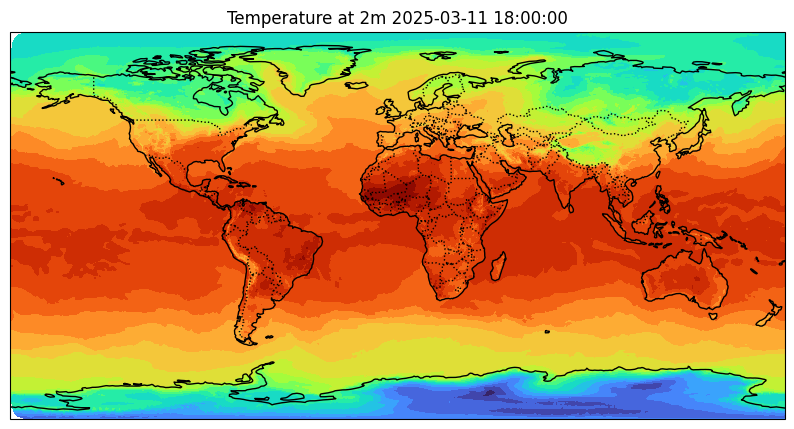

In [18]:
def fix(lons):
    # Shift the longitudes from 0-360 to -180-180
    return np.where(lons > 180, lons - 360, lons)

latitudes = state["latitudes"]
longitudes = state["longitudes"]
values = state["fields"]["2t"]

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

triangulation = tri.Triangulation(fix(longitudes), latitudes)
ax.tricontourf(triangulation, values, levels=20, transform=ccrs.PlateCarree(), cmap="turbo")
plt.title("Temperature at 2m {}".format(state["date"]))
plt.show()